# <font color='blue'>A new webpage's implementation study through A/B Test Results</font>


## Table of Contents
- [Introduction](#intro)
- [Preparing our Dataframe](#probability)
- [A/B Testing](#ab_test)
- [A Regression Approach](#regression)


<a id='intro'></a>
## Introduction


An e-commerce website wants to decide whether or not should they change their webpage to a new one, in order to increase their conversion rate. For this project, we will be working to understand the results of an A/B test, with the objective of helping the company to understand if they should implement the new page or keep the old page, based in the conversion rates observed through a control group, which was presented with the old page, and a treatment group, presented with the new page.


<a id='probability'></a>
### Preparing our Dataframe

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

Now, let's read the csv file in Jupyter Notebook, and take an overall look in the created dataframe:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


The time horizon of the available user data:

In [3]:
print('First row date: {}'.format(df.timestamp.min()))
print('Last row date: {}'.format(df.timestamp.max()))


First row date: 2017-01-02 13:42:05.378582
Last row date: 2017-01-24 13:41:54.460509


The number of rows in the dataset:

In [4]:
print('Number of rows: {}'.format(df.shape[0]))

Number of rows: 294478


The number of unique users in the dataset:

In [5]:
print('Number of unique users: {}'.format(df.user_id.nunique()))

Number of unique users: 290584


The proportion of users converted:

In [6]:
conv_users = df.query('converted == 1').shape[0]
print('Proportion of converted users: {}'.format(conv_users/df.shape[0]))

Proportion of converted users: 0.11965919355605512


We have to verify the cases in which the landing page doesn't correctly identify to the group. The new landing page should be related to the treatment group, and the old page with the control group. This is the number of incorrect matches:

In [7]:
wrong_match = df[((df.group == "treatment") & (df.landing_page != "new_page")) | 
   ((df.group == "control") & (df.landing_page == "new_page"))].shape[0]
print("incorrect matches: {}".format(wrong_match))

incorrect matches: 3893


Verifying if any of the rows have missing values:

In [8]:
df.isna().sum()
print('total of missing values: \n{}'.format(df.isnull().sum()))

total of missing values: 
user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64


For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  With that in mind, let's remove these unnecessary rows:

In [9]:
df2 = df[((df.group == "treatment") & (df.landing_page == "new_page")) | ((df.group == "control") & (df.landing_page == "old_page"))]
df2.shape

(290585, 5)

In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

After it, this is the current number of unique users:

In [11]:
df2.user_id.nunique()

290584

Comparing this result with the shape of the new df2, which is 290585 for the number of rows, we can see that there's one user that is not unique, meaning that there's a duplicated user_id in 2 rows. Let's find this user_id:

In [12]:
df2.user_id.value_counts()[:1]

773192    2
Name: user_id, dtype: int64

In [13]:
df2.query('user_id == 773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


After identifying the user_id and its respective rows, let's remove one of them:

In [14]:
df2.drop([1899], axis=0, inplace=True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [15]:
df2.shape

(290584, 5)

### Conversion Rate analysis

With our dataframe composed only by unique users and the correct relations between landing page and group, let's check our conversion rate. first, let's analyze the conversion without distinguishment between pages or groups and pose some questions about it:

In [16]:
conv_all = df2.converted.mean()
print('probability of converting: {}'.format(conv_all))

probability of converting: 0.11959708724499628


Given that an individual was in the **control** group, what is the probability they converted?

In [17]:
conv_control = df2.query('group == "control"').converted.mean()
print('probability of converting in the control group: {}'.format(conv_control))

probability of converting in the control group: 0.1203863045004612


Given that an individual was in the **treatment** group, what is the probability they converted?

In [18]:
conv_treat = df2.query('group == "treatment"').converted.mean()
print('probability of converting in the treatment group: {}'.format(conv_treat))

probability of converting in the treatment group: 0.11880806551510564


What is the probability that an individual received the new page?

In [19]:
receive_new = df2.query('landing_page == "new_page"').shape[0]/df2.shape[0]
print('probability of receiving the new page: {}'.format(receive_new))

probability of receiving the new page: 0.5000619442226688


**According to the results, the probability of conversion in the new page (treatment group) is smaller than in the old page (control group). Furthermore, the number of individuals in each group doesn't imply any considerable alteration in the probabilities, since both group sizes are very similar.**

<a id='ab_test'></a>
## A/B Testing

Based on all the data provided, and assuming that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, let's define our null and alternative hypothesisin terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

_H0 = P old >= P new_ <br>
_H1 = P old < P new_

Under the null hypothesis, we assume that both $p_{new}$ and $p_{old}$ have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, let's assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br>

with that in mind, let's use a sample size for each page equal to the ones in **ab_data.csv**, and perform a sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null:

a. What is the **conversion rate** for $p_{new}$ under the null? 

In [20]:
p_new = df.converted.mean()
p_new

0.11965919355605512

b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df.converted.mean()
p_old

0.11965919355605512

c. What is $n_{new}$, the number of individuals in the treatment group?

In [22]:
df.query('group == "treatment"').shape[0]

147276

d. What is $n_{old}$, the number of individuals in the control group?

In [23]:
df.query('group == "control"').shape[0]

147202

Now let's simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null, and create a new variable **new_page_converted** to store these $n_{new}$ 1's and 0's in.

In [24]:
new_page_converted = []

for x in range(147275):
    result = np.random.choice([0,1], p= [0.8804, 0.1196])
    new_page_converted.append(result)

now with $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null, to store the result in **old_page_converted**.

In [25]:
old_page_converted = []

for x in range(147202):
    result = np.random.choice([0,1], p= [0.8804, 0.1196])
    old_page_converted.append(result)

We are now able to check the differentes between their conversion rates, by calculation our previous results' means and subtracting them:

In [26]:
diff_p = np.array(new_page_converted).mean() - np.array(old_page_converted).mean()
diff_p

0.001604906539211387

It is observable that the old page got a higher conversion success result concerning these 10.000 iterations... But what about if we ran the same simulation for checking the success rate difference 10.000 times?

In [27]:
p_diffs = []

for x in range(10000):
    p_new = np.random.choice([0,1], size= 147275, p= [0.8804, 0.1196]).mean()
    p_old = np.random.choice([0,1], size= 147202, p= [0.8804, 0.1196]).mean()
    p_diffs.append(p_new - p_old)

Here's a histogram to represent the results:

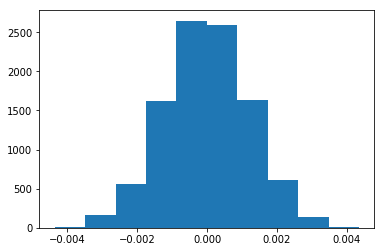

In [28]:
plt.hist(p_diffs);

Below is the proportion of the **p_diffs** that are greater than the actual difference observed in **ab_data.csv**:

In [29]:
p_diff_df2 = df2.query('group=="treatment"')['converted'].value_counts(normalize=True)[1] - df2.query('group=="control"')['converted'].value_counts(normalize=True)[1]
p_diff_df2

-0.0015782389853555567

In [30]:
(p_diffs > p_diff_df2).mean()

0.9032

### Approximately 90% of the proportion differences are greater that the actual difference in ab_data.csv, leading us to fail to reject the null hypothesis. Therefore, it indicates us to maintain the old page.

Here's another approach for the conversion comparison, made through the use of a built-in: 

In [31]:
import statsmodels.api as sm

convert_old = df2.query('converted == 1 & landing_page == "old_page"').shape[0]
convert_new = df2.query('converted == 1 & landing_page == "new_page"').shape[0]
n_old = 147202
n_new = 147275

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [32]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative='smaller')
z_score, p_value

(1.3343647166517898, 0.90895782124190272)

**Since we can observe a Z-score value of 1.33, it tells us that the results are 1.33 standard deviations away from the mean. In parallel, a P-value of approximately 0.9 pushes us away from the null hypothesis. Also, A positive Z-score of 1.33 tells us that the distribution is not unusual/exceptional. In conclusion, we can observe that the conversion rates are higher for the old page.**

<a id='regression'></a>
## A regression approach

### Logistic Regression

Through the use of a logistic regression model, let's see if there is a significant difference in conversion based on which page a customer receives. For that, we will create a dummy variable column for which page each user received, an **intercept** column and an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [33]:
df2['intercept'] = 1
df2[['new_page','old_page']] = pd.get_dummies(df2['landing_page'])
df2[['control','ab_page']] = pd.get_dummies(df2['group'])
df2.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


,user_id,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0


Now we will fit our model to identify if there's a significant relation between the new page and the conversion:

In [34]:
import statsmodels.api as sm
model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


This is the model's summary:

In [35]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 16 Dec 2019   Pseudo R-squ.:               8.077e-06
Time:                        19:36:53   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

**The p-value of ab_page is 0.19, which is beyond the alpha threshold. It differs from the p-value in the previous test because in part II the null hypothesis was defined as  "P old >= p new", while in part III the null was defined as "P old = P new". With that in mind, the ab_page variable in part III has a smaller P-value, due to the value amplitude being larger on the logistic regression (two-tailed).

**A correlation analysis can be drastically altered with the inclusion (or exclusion) of exogenous variables. If you choose to insert other factors into your model, you'll be given the chance to unravel insighthful discoveries, which will grant you a better comprehension about the dependent variable, and it's a good practice to adopt different angles and perspectives during your EDA. On the other hand, you should be careful with certain aspects such as the rise of false positives, intercollinearity risks and other multiple comparison issues, which must be addressed with different methods depending on the scenario.**

### To check the exogenous variables' influence, let's input the country variable, to observe if there's any relevant alteration in the regression model's results, extracting it from another file:

In [46]:
df_country = pd.read_csv('countries.csv')
df_country.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [47]:
df3 = df2.set_index('user_id').join(df_country.set_index('user_id'))
df3.head(8)

,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,country
user_id,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,US
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,US
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US
936923,2017-01-10 15:20:49.083499,control,old_page,0,1,0,1,1,0,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,0,0,1,CA
719014,2017-01-17 01:48:29.539573,control,old_page,0,1,0,1,1,0,US


In [48]:
df3[['CA','UK','US']] = pd.get_dummies(df3.country)
df3.head()

,timestamp,group,landing_page,converted,intercept,new_page,old_page,control,ab_page,country,CA,UK,US
user_id,,,,,,,,,,,,,
851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,1,1,0,US,0,0,1
804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,1,1,0,US,0,0,1
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,0,0,1,US,0,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,0,0,1,US,0,0,1
864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,1,1,0,US,0,0,1


Let's check the dependent and independent variable's correlation, with **country** being the only exogenous variable:

In [49]:
model = sm.Logit(df3['converted'], df3[['intercept', 'UK', 'US']] )
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 12 Dec 2019   Pseudo R-squ.:               1.521e-05
Time:                        17:19:21   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
US             0.0408      0.027      1.518      0.129      -0.012       0.093
==============================================================================
"""

**By checking the results, if we consider the alpha threshold at 0.05, there is not a significance between country and conversion.**

now we'll look whether an interaction between **ab_page** and **country** has a significant effect on conversion:

In [79]:
model = sm.Logit(df3['converted'], df3[['intercept', 'ab_page', 'UK', 'US']])
result = model.fit()
result.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 10 Dec 2019   Pseudo R-squ.:               2.323e-05
Time:                        22:37:17   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

**Again, considering a threshold of alpha at 0.05, we do not have significance between the interation among countries and pages to the conversion rate**

<a id='conclusions'></a>
## Conclusion <br>

After analyzing the data provided, it is plausible to say that the deployment of a new web page will not necessarily accrue higher conversion rates. Through the hypothesis testing applied in this project, we fail to reject the null, demonstrating technical evidence of no significant relation between the variables. However, this study utilizes a database containing observations made in a shorter than 1 month period, which brings us the question if these observations should persist for longer, concerning intrinsic issues such as the Novelty Effect or change aversion.
For now, with the data at hand the e-commerce website should persist in using the current web page, giving them the opportunity to search for different optimizations or changes to try to boost their conversion numbers.


In [48]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0